In [2]:
#1. Численно промоделировать движение тысячи частиц.
#• Начальные положения: равномерно распределены  (По Гауссу сука)
#• Начальные скорости равномерно распределены () по углу, постоянны по модулю.
#• Частицы отражаются от “стенок коробки” (-1, -1) — (-1, 1) — (1, 1) — (1, -1) — (-1, -1),
# за исключением “отверстия” (1, -0.1) — (1, 0.1).
#• Нарисовать положения всех частиц через время t.
#• Анимировать движение частиц.
#• Нарисовать двумерную гистограмму плотности частиц через время t.

In [26]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

class particles:
    '''Particles in the cube class
    
    init_state is 'normal'  for uniform distribution (this is the usual condition)
                  'circle'  to post all particle in the circle area
                  'circuit' to place all of them on a cirtuit
                  'source'  to put a source of the particles in the center
                  'square'  to post all particle in the square area

    amount_pc for amount of particles

    collitions is condition to collide particles or not

    has_hole is condition for cube to have a hole in there 

    tempreture in °C - initial condition to calculate most probable velocity
    
    M in  g/mol - molar mass of argon molecules
        
        |Molar mass table for some elements or compounds: |  
        |   Elements or compounds    Molar mass, g/mol    |
        |            N2                      28           |
        |            Ar                      40           |
        |            H2                       2           |
        |            He                       4           |
        |            Air                     29           |
        |            O2                      32           |
        
    density in kg/m^3 - density of the gas for computing minimal distance for undergo a collision (2*particles.R)
        
        |     Density table for some gases under NC:      |
        |           Gas               Density, kg/m^3     |
        |            N2                    1.250          |
        |            Ar                    1.784          |
        |            H2                    0.090          |
        |            He                    0.178          |
        |            Air                   1.293          |
        |            O2                    1.429          |
    
    bounds - boundaries for the cube
    
    '''
    def __init__(self,
                 init_state = 'normal', #we will define it below
                 amount_pc = 500,
                 collisions = True,
                 has_hole = True,
                 tempreture = 20,
                 M = 39.948,
                 density = 1.784, #можно короче ещё расчитывать плотность по формуле для ид. газа, но давление будет меняться со временем, поэтому не будем пока
                 bounds = ((1,0.1), (1,1), (-1,1), (-1,-1), (1,-1), (1,-0.1))):
        
        self.amount_pc = amount_pc
        self.collisions = collisions
        self.has_hole = has_hole
        self.Vm0 = np.sqrt(2*8.31*(tempreture + 273.15)/M*1000)
        #self.m = M/1000*amount_pc/(6.022* 10**23) #это кажется просто бесполезно, т.к. газ не включает примеси
        self.R = (3*(M/1000)/(4*np.pi*6.022* 10**23*density))**(1/3)* (10**7)
        self.bounds = np.asarray(bounds)
        self.current_amount = amount_pc
        
        a = np.random.uniform(0, 2*np.pi, self.amount_pc)
        g = np.random.uniform(0, 2*np.pi, self.amount_pc)
        r = np.random.uniform(0, 0.5, self.amount_pc)
        vx = self.Vm0*np.cos(a)
        vy = self.Vm0*np.sin(a)
        
        distribution = {
            'normal': np.random.uniform(-1 + self.R, 1 - self.R, (2,self.amount_pc)).T,
            'circle': np.asarray([r*np.cos(g), r*np.sin(g)]).T,
            'circuit': np.asarray([0.5*np.cos(g), 0.5*np.sin(g)]).T,
            'source': np.asarray([r*np.cos(a), r*np.sin(a)]).T,
            'square': np.random.uniform(-0.4, 0.4, (2,self.amount_pc)).T
        }
        
        self.init_state = np.insert(distribution[init_state], 2, [vx,vy], axis = 1)
        self.state = self.init_state.copy()
        self.time_elapsed = 0

    def step(self, dt):
        '''One step in dt seconds'''
        self.time_elapsed += dt
        
        #updating positions
        self.state[:,:2] += self.state[:,2:]*dt #о, да двумерный слайсинг!
        
        #who's going to collide?
        D = squareform(pdist(self.state[:, :2]))
        ind1, ind2 = np.where(D < 2 * self.R)
        unique = (ind1 < ind2)
        ind1 = ind1[unique]
        ind2 = ind2[unique]
        
        if self.collisions:
            #update velocities of colliding pairs
            for i1, i2 in zip(ind1, ind2):
                #positions vector
                r1, r2 = self.state[i1, :2], self.state[i2, :2]

                #velocity vector
                v1, v2 = self.state[i1, 2:], self.state[i2, 2:]
            
                # relative location & velocity vectors
                r = r1 - r2
                v = v1 - v2

                #velocity of the center of mass
                v0 = (v1 + v2) / 2

                #collisions of spheres reflect v over r
                absr = np.dot(r, r)
                vdotr = np.dot(v, r)
                n0 = 2 * r * vdotr / absr - v

                # assign new velocities
                self.state[i1, 2:],  self.state[i2, 2:] = n0 * 1 / 2 + v0, - n0 * 1 / 2 + v0
        
        #checking for crossing boundaries
        goes_out_x1 = (self.state[:,0] + self.R) > self.bounds[0][0]
        goes_out_y1 = (self.state[:,1] + self.R) < self.bounds[0][1]
        goes_out_y6 = (self.state[:,1] + self.R) > self.bounds[-1][1]
        
        #crossed_xy = np.array([])
        #for p in self.bounds:
        #crossed_xy = (self.state[:,] + )
        # хотелось бы зная векторы вершин коробки по этому проверять, но пока так
        
        crossed_y2 = (self.state[:,1] + self.R) > self.bounds[1][1]
        crossed_x3 = (self.state[:,0] - self.R) < self.bounds[2][0]
        crossed_y4 = (self.state[:,1] - self.R) < self.bounds[3][1]
        
        #changing position
        self.state[(goes_out_x1 & ~goes_out_y1 & ~goes_out_y6), 0] = self.bounds[0][0] - self.R
        self.state[crossed_y2 & ~goes_out_x1, 1] = self.bounds[1][1] - self.R
        self.state[crossed_x3, 0] = self.bounds[2][0] + self.R
        self.state[crossed_y4 & ~goes_out_x1, 1] = self.bounds[3][1] + self.R
        
        
        #reverting normal component of velocity
        if self.has_hole:
            self.state[goes_out_x1 & ~goes_out_y1, 2] *= -1
            self.state[(goes_out_x1 & ~goes_out_y6) | crossed_x3, 2] *= -1
            
            #updating amount of particles in the cube
            self.current_amount = self.current_amount - np.sum(goes_out_x1 & goes_out_y1 & goes_out_y6)
        
            #deleting particles who goes out
            self.state = np.delete(self.state, np.where(goes_out_x1 & goes_out_y1 & goes_out_y6), axis = 0)
            crossed_y2 = np.delete(crossed_y2, np.where(goes_out_x1 & goes_out_y1 & goes_out_y6), axis = 0) 
            crossed_y4 = np.delete(crossed_y4, np.where(goes_out_x1 & goes_out_y1 & goes_out_y6), axis = 0)
            
            #тут можно до удаления запоминать направление скорости и составить гистограмму направлений вылета из дырки
            
        else:
            self.state[goes_out_x1 | crossed_x3, 2] *= -1 #это условие на коробку
        
        self.state[(crossed_y2 | crossed_y4), 3] *= -1        

        #we can also add gravity in one second, but we didn't
        
        
        

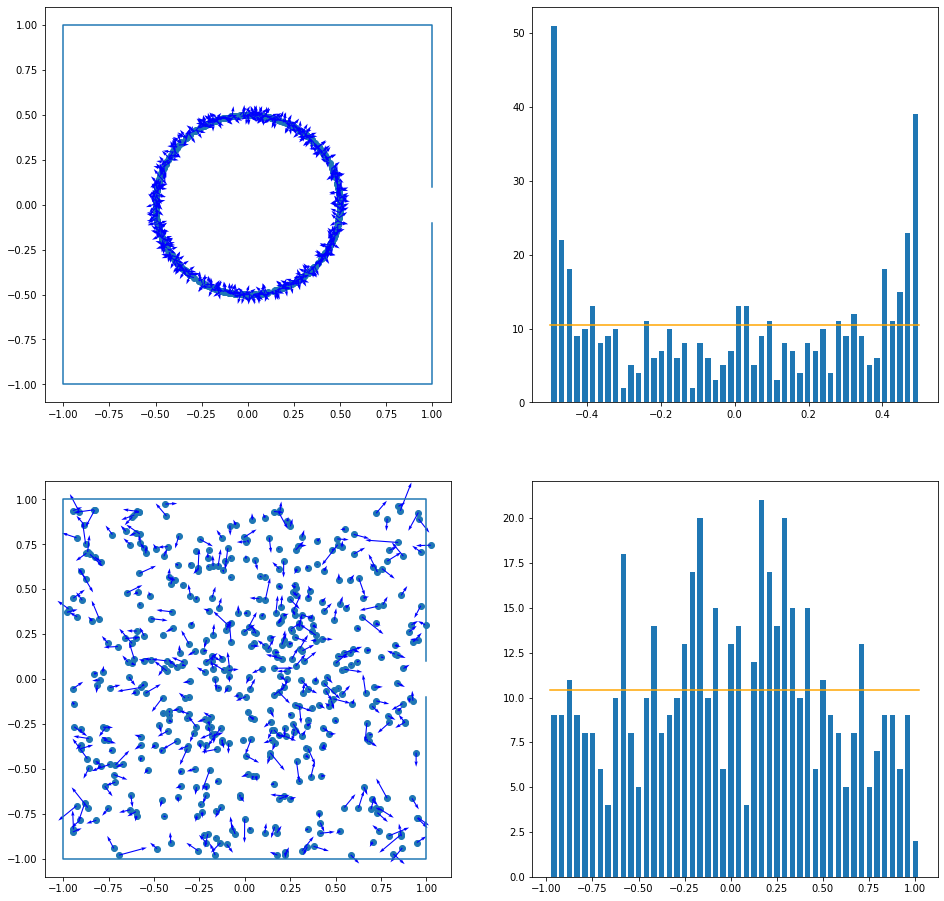

In [28]:
import matplotlib.pyplot as plt
from matplotlib import animation

pc = particles('circuit', 500)

%matplotlib inline
fig = plt.figure(figsize = (16, 16))

axp0 = fig.add_subplot(221)
axp0.scatter(pc.init_state[:,0], pc.init_state[:,1])
axp0.plot(pc.bounds[:,0], pc.bounds[:,1])
if not pc.has_hole: axp0.plot(pc.bounds[::-len(pc.bounds)+1,0], pc.bounds[::-len(pc.bounds)+1,1])
axp0.quiver(pc.init_state[:,0], pc.init_state[:,1], pc.init_state[:,2], pc.init_state[:,3], color = 'blue')

#  import pandas as pd
#  df = pd.DataFrame(pc.state[:,:2], columns = ['x','y'])
#
#  нужно составить массив плотности n(x)
#  n0 = [len(df.loc[(x - pc.R < df['x']) & (df['x'] < x + pc.R)])/pc.current_amount for x in np.arange(-1 + pc.R, 1 - pc.R, 2*pc.R)]
#    Итак, массив плотности составлять не нужно было, стоило только сделать гистограмму от координат
#    Однако поощерю, за выполненное посвящение в библеотеку pandas
#    В этой середине кода поздравляю вас с выполненными заданиями на 4
#  print(df.loc[(0 - pc.R < df['x']) & (df['x'] < 0 + pc.R)])
#  print('\n')
#  print(len(df.loc[(0 - pc.R < df['x']) & (df['x'] < 0 + pc.R)])/pc.current_amount)
#  print(np.arange(-1 + pc.R, 1 - pc.R, 2*pc.R))

axn0 = fig.add_subplot(222)
hist, bins = np.histogram(pc.state[:,0], bins = len(np.arange(-1 + pc.R, 1 - pc.R, 2*pc.R)))
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
axn0.bar(center, hist, align='center', width = width)
axn0.plot(bins,[np.mean(hist) for x in bins], c = 'orange')


t = 0.002 #(sec) - after the initial state
dt = 10**-4
for i in range(int(t/dt)): pc.step(dt)

axpt = fig.add_subplot(223)
axpt.scatter(pc.state[:,0], pc.state[:,1])
axpt.plot(pc.bounds[:,0], pc.bounds[:,1])
if not pc.has_hole: axpt.plot(pc.bounds[::-len(pc.bounds)+1,0], pc.bounds[::-len(pc.bounds)+1,1])
axpt.quiver(pc.state[:,0], pc.state[:,1], pc.state[:,2], pc.state[:,3], color = 'blue')

axnt = fig.add_subplot(224)
hist, bins = np.histogram(pc.state[:,0], bins = len(np.arange(-1 + pc.R, 1 - pc.R, 2*pc.R)))
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
axnt.bar(center, hist, align='center', width = width)
axnt.plot(bins,[np.mean(hist) for x in bins], c = 'orange')

plt.grid(False)

<IPython.core.display.Javascript object>


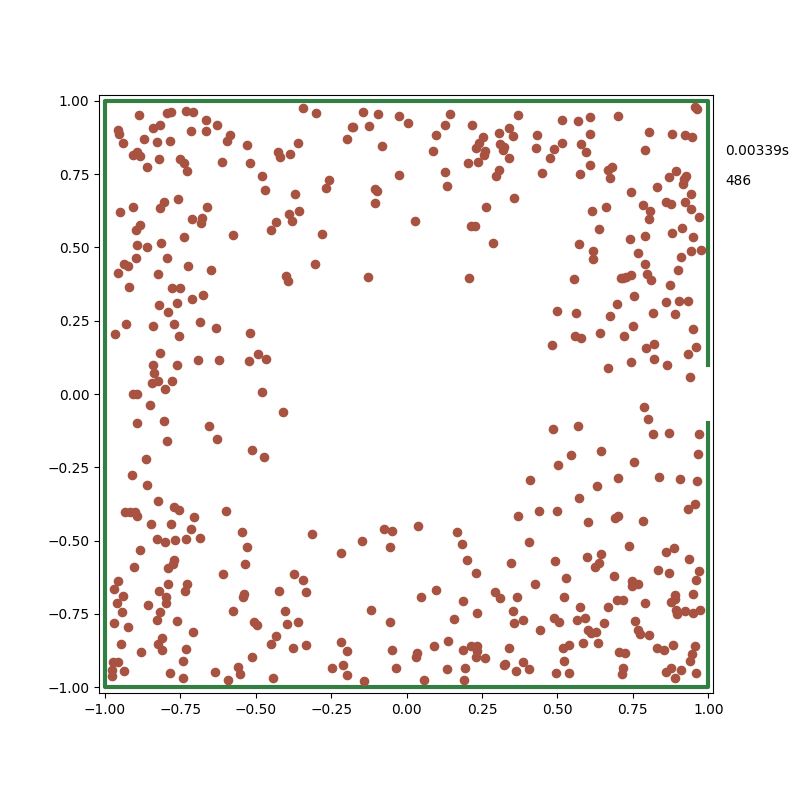

In [39]:
import matplotlib.pyplot as plt
from matplotlib import animation

%matplotlib notebook
fig = plt.figure(figsize = (8, 8))
ax = plt.axes(xlim = (-1.02, 1.015), ylim = (-1.02, 1.02)) #круто, так можно задавать границы, наконец-то мы это узнали

pc = particles('square', 500, collisions = False)

ax.plot(pc.bounds[:,0], pc.bounds[:,1], linewidth = 3, color = '#317F43')
pcd, = ax.plot(pc.init_state[:,0], pc.init_state[:,1], 'bo', color = '#A85341', lw = 0)
time_text = ax.text(1.02, 0.9, '', transform=ax.transAxes)
len_text = ax.text(1.02, 0.85, '', transform=ax.transAxes)

dt = 10**-5

def init():
    """initialize animation"""
    pcd.set_data([], [])
    time_text.set_text('')
    len_text.set_text('')
    return pcd, time_text, len_text

def redraw(i):  
    global pc, dt
    pc.step(dt)
    
    pcd.set_data(pc.state[:,0], pc.state[:,1])
                
    time_text.set_text('%.5fs' % pc.time_elapsed)
    len_text.set_text('%d' % pc.current_amount)
    return pcd, time_text, len_text
    
anim = animation.FuncAnimation(fig, redraw, frames = 600, interval = 10, blit = True, init_func = init)
#plt.show()

In [6]:
import numpy as np
x= [1,2,3,4,5,6]
y= [11,12,13,14,15,16]

z=[[x,y[i]] for x in x for i in range(6)]
z = np.array(z)
vx= np.linspace(-10, 0, 36)
vy= np.linspace(-100, -50, 36)
print(vx.shape)
#np.insert(z, 2, [vx,vy], axis = 1)

(36,)


In [166]:
x1 = np.asarray([True,False,True,True,True,False,False,False,True])
x2 = np.asarray([True,False,False,False,False,False,True,True,True])
y1 = np.asarray([True,False,True,False,False,False,True,False,True])
y2 = np.asarray([True,True,True,True,True,True
                 ,False,True ,True])
goes_out = []
print(len(x1))

for i,j,k,l in zip(x1,x2,y1,y2):
    if i and j and k and l : goes_out.append(True)
    else: goes_out.append(False)
        
x = np.asarray([x + 2 for x in range(len(x1))])
y = np.zeros(len(x1), dtype='bool')

print(f'\n{x1}\n{~y2}\n{~y1}\n{x1 & ~y2 & ~y1}\n{np.sum(y)}')

9

[ True False  True  True  True False False False  True]
[False False False False False False  True False False]
[False  True False  True  True  True False  True False]
[False False False False False False False False False]
0


In [207]:
#tt = particles(amount_pc = 9)
tt.state[1][:]

#нужно конвертировать массив логических значений в индекс, на которых стоит True
#tt.state[:,:2] 
z1 = np.asarray([1,2,3,4,5,6,7])
z2 = np.


np.where()

#print(f'{tt.state},\n\n {np.where},\n\n {np.delete(tt.state, [0,2], axis = 0)}')

(array([0, 2, 3, 4, 8], dtype=int32),)

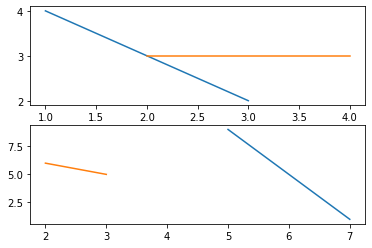

In [4]:
from matplotlib import pyplot as PLT

fig = PLT.figure()

ax1 = fig.add_subplot(211)
ax1.plot([(1, 2), (3, 4)], [(4, 3), (2, 3)])

ax2 = fig.add_subplot(212)
ax2.plot([(7, 2), (5, 3)], [(1, 6), (9, 5)])

PLT.show()

In [19]:
pc = particles(amount_pc = 50)
df = pd.DataFrame(pc.state[:,:2], columns = ['Positions: x','y'])
df

,Positions: x,y
0,-0.068059,0.162879
1,0.479447,-0.601021
2,-0.244410,-0.305661
3,-0.690789,0.771702
4,-0.374434,0.036489
5,-0.794025,-0.512697
6,0.023290,0.594023
7,0.657597,0.186106
8,-0.223469,-0.840793
9,0.706003,0.706330
